In [41]:
%reload_ext autoreload
%autoreload 2

In [42]:

import math
import os
from sklearn.model_selection import train_test_split
import skimage.color as color
import numpy as np
np.set_printoptions(suppress=True)
from colors import ColorsCorpusReader
import colorsys


COLORS_SRC_FILENAME = os.path.join("data", "colors", "filteredCorpus.csv")


## Class to hold target color and text

In [33]:


def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color_context(lab_cs):

    color_arr = np.asarray(lab_cs)
    max_arr   = np.argmax(color_arr, axis=0)   
    min_arr   = np.argmin(color_arr, axis=0) 
    color_arr[           : ,0] =  0.0
    color_arr[  max_arr[0] ,0] =  1.0
    color_arr[  min_arr[0] ,0] = -1.0

    return color_arr

def represent_color(lab,d_model):
    a    = np.pi
    size = d_model - 1 
    c = [ np.dot( lab , [1.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,d_model,1) ]
    return np.array(c)

class ColorDataset() :

    def __init__(self,exs,d_model=128) :

        self.d_model = d_model
        # print(f"embedding dimension for a color :{self.d_model}")

        # turns a set of 3 rgb colors into 3 lab colors in context
        lab_colors      = lambda rgb_colors : represent_color_context( [ return_color(rgb_color) for rgb_color in rgb_colors] ) 

        # turns a set of 3 lab colors into 3 lab embeddings (each d_model dimensions)
        lab_embeddings  = lambda lab_colors : [ represent_color(lab_color,d_model) for lab_color in lab_colors ] 

        # retrieves hls colors and text list from examples
        all_hls_colors, self.texts  = zip(*[[ex.colors, ex.contents] for ex in exs])

        # converts hls colors to rgb colors
        all_rgb_colors            = [ [colorsys.hls_to_rgb(*color) for color in colors] for colors in all_hls_colors]

        # converts rgb colors to lab colors
        all_lab_colors            = [ lab_colors(rgb_colors) for rgb_colors in all_rgb_colors]

        # converts lab colors to lab embeddings
        all_lab_embeddings        = [ lab_embeddings(lab_colors) for lab_colors in all_lab_colors]

        # selects the target embedding correspnding to the target text
        self.target_embeddings           = [ lab_embeddings[2] for lab_embeddings in all_lab_embeddings] 

        # selects the target rgb color corresponding to the target text
        self.target_rgbs                 = [ rgb_colors[2]     for rgb_colors     in all_rgb_colors    ] 

        print(f"number of examples     :{len(self.texts)}" )


  

## Create datasets with embedding and text

- dataset.target_embeddings[0]
- dataset.target_rgbs[0]
- dataset.texts[0]

In [34]:

corpus   = ColorsCorpusReader(COLORS_SRC_FILENAME,word_count=None, normalize_colors=True)
examples = list(corpus.read())

EMB_SIZE           = 128 

far_examples  =  [ex for ex in examples if ex.condition == "far" ]
split_examples = [ex for ex in examples if ex.condition == "split" ]
close_examples = [ex for ex in examples if ex.condition == "close" ]


far_train  , far_test   = train_test_split(far_examples  ,train_size=.8)
close_train, close_test = train_test_split(close_examples,train_size=.8)
split_train, split_test = train_test_split(split_examples,train_size=.8)

far_train_ds, far_test_ds     = ColorDataset(far_train,d_model=EMB_SIZE) , ColorDataset(far_test,d_model=EMB_SIZE)
close_train_ds, close_test_ds = ColorDataset(split_train,d_model=EMB_SIZE),ColorDataset(close_test,d_model=EMB_SIZE) 
split_train_ds, split_test_ds = ColorDataset(close_train,d_model=EMB_SIZE), ColorDataset(split_test,d_model=EMB_SIZE) 


number of examples     :12625
number of examples     :3157
number of examples     :12554
number of examples     :3104
number of examples     :12415
number of examples     :3139


## Plot the first 10 color representations, along with the text that goes with it

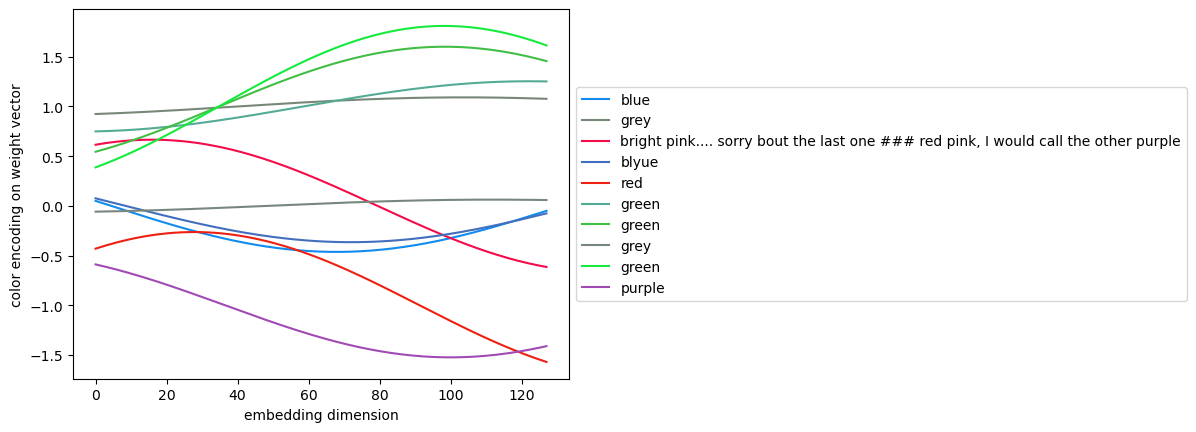

In [40]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(dataset, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.target_embeddings[i], color=dataset.target_rgbs[i], label=dataset.texts[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

visualize(far_train_ds,range(0,10))
